In [4]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
from PIL import Image
from collections import deque

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game, get_valid_actions

from agent_code.simple_agent.wrapper import SimpleAgent

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX3 as game_state_X
from agent_code.tensor_agent.X import AbsoluteX3, X3_to_imgs
from agent_code.tensor_agent.model import FullModel, Counter

choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
action_y_map = {choices[i]: i for i in range(len(choices))}
D = len(choices)

clear_output()

In [5]:
hp.buffer_size = 10000
hp.target_network_period = 1000
hp.epsilon = 0.
hp.learning_rate=0.001
hp.discount_factor=0.9
hp.peaceful = False
hp.multi_step_n = 3

aux_rewards = {
    e.WAITED: -0.2,
    e.CRATE_DESTROYED: 0.2,
    e.COIN_COLLECTED: 0,
    e.KILLED_OPPONENT: 0,
    e.KILLED_SELF: 0,
    e.GOT_KILLED: -5
}

last_moves_length = 20
last_moves_similarity_penalty = 1 / last_moves_length

hurry_up = 1 * (1 - hp.discount_factor)

In [18]:


K.clear_session()
#model = FullModel(game_state_X.shape, D)

def make_agent():
    return TensorAgent(game_state_X.shape, D, weights=None, model=FullModel(game_state_X.shape, D))

total_step = 0

tensor_agent = make_agent()

original = 'tensor_agent'
agents = {
    original: tensor_agent
}

train = {a: False for a in agents}

clear_output()

In [19]:
class AgentInfo(object):
    def __init__(self, agents, moving_rewards):
        self.agents = agents
        self.moving_rewards = moving_rewards

    def _repr_pretty_(self, pp, cycle):
        text = ''
        for n, a in self.agents.items():
            text +=  '=====================\n'
            text += f'{n} ({a.model.family}) \n'
            text += f'trained: {a.model.steps} \n'
            text += f'moving reward: {moving_rewards[n]:.2f} \n'
        pp.text(text)
        
    def __repr__(self):
        return str(self.agents.keys().join(','))

In [24]:
d = display(f'Starting...', display_id='progress')


n_steps = 200000
game = None
current_agents = {}

train = {n: False for n in agents.keys()}
for n in [original]:
    train[n] = True
#train['tensor_agent'] = True

moving_rewards = {n: 0 for n in agents.keys()}
episode_count = 0

info = AgentInfo(agents, moving_rewards)
agent_display = display(info, display_id='agent_info')

coins_collected = deque(maxlen=10000)
coins_found = []


for step in range(total_step, n_steps):
    if game is None:
        episode_count += 1
        
        #=== Choose Agents ===
        agent_choice = 'solo'
        current_agents = {n: agents[n] for n in [original]}
        
        last_moves = {n: deque(maxlen=last_moves_length) for n in current_agents.keys()}
        
        
        #=== Choose Game ===
        game = Game(*Game.create_arena(current_agents.keys(),\
                                       crate_density=np.random.uniform(low=0.5, high=1.0)), \
                   max_duration=np.random.randint(200, 401))

    total_step += 1
    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, b, game, prevent_death=False)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards, events = game.step(actions_as_string)
    
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
        reward = rewards[name] + np.sum([events[name][event] * aux_rewards[event] for event in aux_rewards.keys()])
        
        reward -= last_moves[name].count((x, y, actions[name])) * last_moves_similarity_penalty
        last_moves[name].append((x, y, actions[name]))
        
        moving_rewards[name] = 0.99 * moving_rewards[name] + reward
        
        if train[name]:
            current_agents[name].reward_update([Xs[name], actions[name], reward])
    
    coins_collected.append(rewards['tensor_agent'])
    coins_found.append(np.sum(coins_collected))
    
    agent_display.update(info)
    
    if game.terminated:
        for name, a in current_agents.items():
            a.end_of_episode() # alt: save=None
        
        d.update(f'Episode {episode_count} Step: {step+1}/{n_steps}')
        game = None

d.update(f'Complete')

'Complete'

tensor_agent (flamboyant_coin_lover) 
trained: 47499 
moving reward: -9.73 


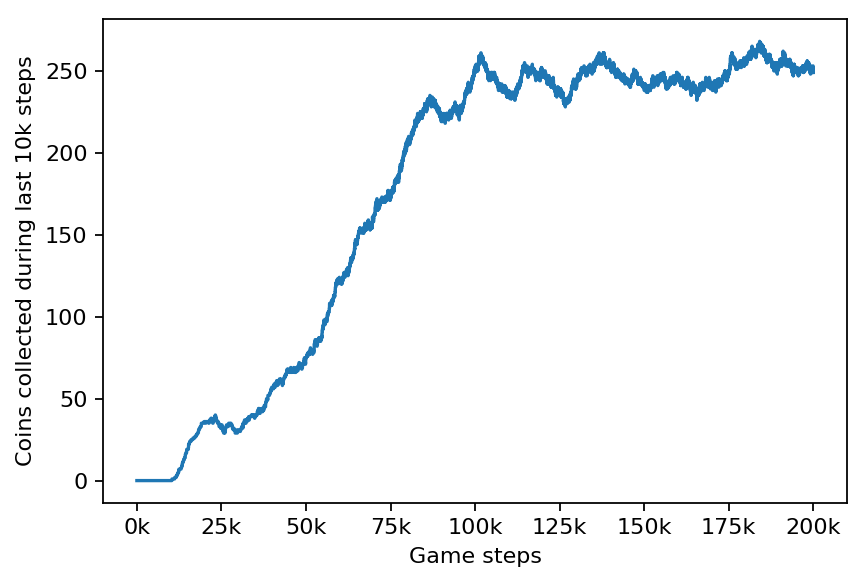

In [39]:
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
figure(num=None, dpi=160, facecolor='w', edgecolor='k')

plt.plot(coins_found)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: '%1.0fk' % (x*1e-3)))

#plt.legend()
plt.ylabel('Coins collected during last 10k steps')
plt.xlabel('Game steps')
plt.show()

In [26]:
tensor_agent.model.save(f'singleplayer-200k.h5')

In [40]:
performance['crate-aux-reward'] = coins_found

In [41]:
hp.buffer_size = 10000
hp.target_network_period = 1000
hp.epsilon = 0.
hp.learning_rate=0.001
hp.discount_factor=0.99
hp.peaceful = False
hp.multi_step_n = 3

aux_rewards = {
    e.WAITED: -0.2,
    e.CRATE_DESTROYED: 0,
    e.COIN_COLLECTED: 0,
    e.KILLED_OPPONENT: 0,
    e.KILLED_SELF: 0,
    e.GOT_KILLED: 0
}

last_moves_length = 20
last_moves_similarity_penalty = 1 / last_moves_length

hurry_up = 1 * (1 - hp.discount_factor)

In [43]:


K.clear_session()
#model = FullModel(game_state_X.shape, D)

def make_agent():
    return TensorAgent(game_state_X.shape, D, weights=None, model=FullModel(game_state_X.shape, D))

total_step = 0

tensor_agent = make_agent()

original = 'tensor_agent'
agents = {
    original: tensor_agent
}

train = {a: False for a in agents}

clear_output()

In [46]:
d = display(f'Starting...', display_id='progress')


n_steps = 200000
game = None
current_agents = {}

train = {n: False for n in agents.keys()}
for n in [original]:
    train[n] = True
#train['tensor_agent'] = True

moving_rewards = {n: 0 for n in agents.keys()}
episode_count = 0

info = AgentInfo(agents, moving_rewards)
agent_display = display(info, display_id='agent_info')

coins_collected = deque(maxlen=10000)
coins_found = []


for step in range(total_step, n_steps):
    if game is None:
        episode_count += 1
        
        #=== Choose Agents ===
        agent_choice = 'solo'
        current_agents = {n: agents[n] for n in [original]}
        
        last_moves = {n: deque(maxlen=last_moves_length) for n in current_agents.keys()}
        
        
        #=== Choose Game ===
        game = Game(*Game.create_arena(current_agents.keys(),\
                                       crate_density=np.random.uniform(low=0.5, high=1.0)), \
                   max_duration=np.random.randint(200, 401))

    total_step += 1
    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, b, game, prevent_death=False)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards, events = game.step(actions_as_string)
    
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
        reward = rewards[name] + np.sum([events[name][event] * aux_rewards[event] for event in aux_rewards.keys()])
        
        reward -= last_moves[name].count((x, y, actions[name])) * last_moves_similarity_penalty
        last_moves[name].append((x, y, actions[name]))
        
        moving_rewards[name] = 0.99 * moving_rewards[name] + reward
        
        if events[name][e.GOT_KILLED] > 0:
            reward -= events[name][e.GOT_KILLED] * np.sum(game.coins)
        
        if train[name]:
            current_agents[name].reward_update([Xs[name], actions[name], reward])
    
    coins_collected.append(rewards['tensor_agent'])
    coins_found.append(np.sum(coins_collected))
    
    agent_display.update(info)
    
    if game.terminated:
        for name, a in current_agents.items():
            a.end_of_episode() # alt: save=None
        
        d.update(f'Episode {episode_count} Step: {step+1}/{n_steps}')
        game = None

d.update(f'Complete')

'Complete'

tensor_agent (flamboyant_coin_lover) 
trained: 47499 
moving reward: -9.73 


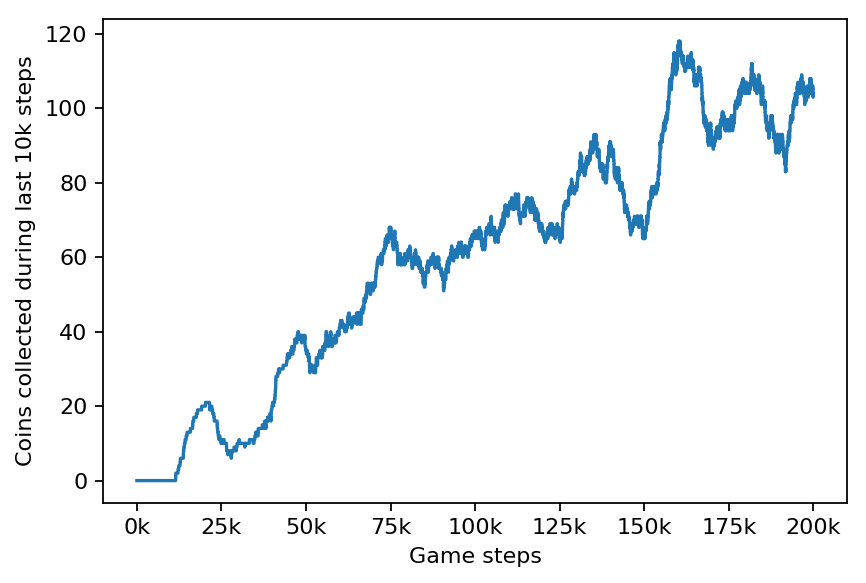

In [47]:
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
figure(num=None, dpi=160, facecolor='w', edgecolor='k')

plt.plot(coins_found)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: '%1.0fk' % (x*1e-3)))

#plt.legend()
plt.ylabel('Coins collected during last 10k steps')
plt.xlabel('Game steps')
plt.show()

In [54]:
d = display(f'Starting...', display_id='progress_test')

n_steps = 1000
game = None

current_agents = {n: agents[n] for n in [original]}
train = {n: False for n in agents.keys()}
moving_rewards = {n: 0 for n in current_agents.keys()}

info = AgentInfo(current_agents, moving_rewards)
agent_display = display(info, display_id='agent_info_test')

imgs = []

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.75))

    actions = {}
    Xs = {}
    img = np.zeros((17, 17, 4))
    
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        #img[:,:,0] = (game_state['arena'] == -1) * 0.75
        #img[:,:,0] += game_state['arena'] == 1
        #coins = game_state['coins']
        #for i in range(len(coins)):
        #    img[coins[i][0], coins[i][1], 1] = 0.75
        #img[x,y,1] = 1
        #img[:,:,2] = game_state['explosions'] / np.max(game_state['explosions'])
        #bombs = game_state['bombs']
        #
        #for i in range(len(bombs)):
        #    img[bombs[i][0], bombs[i][1], 2] = 0.75 - bombs[i][2] / (s.bomb_timer) / 2
        
        Xs[name] = game_state_X.get(game_state)
        _, img = X3_to_imgs(AbsoluteX3.get(game_state), whitening=10)
        
        valid_actions = get_valid_actions(x, y, b, game)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    imgs.append(img)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    print(actions_as_string)
    rewards, events = game.step(actions_as_string)
    
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
    
    d.update(f'Step: {step+1}/{n_steps}')
    agent_display.update(info)
    
    if game.terminated:
        #for name, a in agents.items():
            #a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        game_state = game.get_game_state(None)
        _, img = X3_to_imgs(AbsoluteX3.get(game_state))
        imgs.append(img)
        break


'Step: 21/1000'

tensor_agent (flamboyant_coin_lover) 
trained: 47499 
moving reward: 0.00 


{'tensor_agent': 'RIGHT'}
{'tensor_agent': 'BOMB'}
{'tensor_agent': 'LEFT'}
{'tensor_agent': 'UP'}
{'tensor_agent': 'DOWN'}
{'tensor_agent': 'UP'}
{'tensor_agent': 'WAIT'}
{'tensor_agent': 'BOMB'}
{'tensor_agent': 'DOWN'}
{'tensor_agent': 'RIGHT'}
{'tensor_agent': 'RIGHT'}
{'tensor_agent': 'RIGHT'}
{'tensor_agent': 'RIGHT'}
{'tensor_agent': 'UP'}
{'tensor_agent': 'UP'}
{'tensor_agent': 'BOMB'}
{'tensor_agent': 'RIGHT'}
{'tensor_agent': 'WAIT'}
{'tensor_agent': 'WAIT'}
{'tensor_agent': 'WAIT'}
{'tensor_agent': 'WAIT'}


In [55]:
game.score

{'tensor_agent': 0}

In [13]:
! rm anim/*
for i in range(len(imgs)):
    Image.fromarray(np.uint8(imgs[i]*255)).resize((17*10,17*10)).save('anim/{:0>3d}.png'.format(i))

In [14]:
! convert anim/*.png movie.gif